# Dataset preparation

## Import Packages

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Load and Prepare Data

The data for the road accidents from the Metropolitan Manila Development Authority (MMDA) twitter posts were retreived from **Kaggle**.
Reference: https://www.kaggle.com/code/esparko/getting-started-tweet2map-dataset/input

In [11]:
data = pd.read_csv("data_mmda_traffic_spatial.csv")
data = data[(data['Latitude'] != 0.0) & (data['Longitude'] != 0.0) & (data['Time'] != 0.0) & (data['Date'] != 0.0)]

 The rows with empty data values for the Longitude, Latitude, Date, and Time features will be dropped from the dataset to avoid inconsistencies with the results.

# Clustering similar accident locations

## Pre-process the data and set the feature variables to be used

In [3]:
features = data[["Latitude", "Longitude"]]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

< explanation >

## Determine the appropriate number of clusters using the elbow method

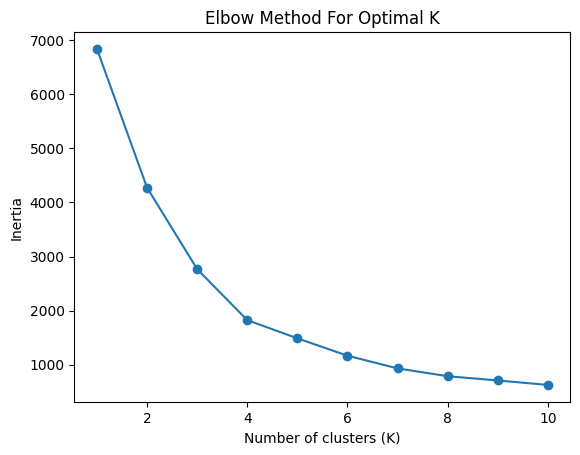

In [5]:
inertia = []

for K in range(1, 11):
    kmeans = KMeans(n_clusters=K, init = 'k-means++', n_init = 10, random_state=0)
    clusters = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, 'o-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()

Based on the plot, the inertia starts to slow down at K=4. This would mean that K=4 is a good estimate for the optimal number of clusters.

## Perform clustering using the K-means algorithm

Using the optimal number of clusters, K=4, we proceed with using the K-means algorithm to cluster the frequency of road accidents according to Latitude and Longitude.

In [8]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init = 4)
kmeans.fit(scaled_features)

KMeans(n_clusters=4, n_init=4)

Label the clusters

In [9]:
data['cluster'] = kmeans.labels_

Show the clusters

In [10]:
for cluster_id in range(num_clusters):
    cluster_data = data[data['cluster'] == cluster_id]
    print(f'Cluster {cluster_id}:')
    print(cluster_data[['Latitude', 'Longitude']])
    print('------------------------------------')

Cluster 0:
       Latitude   Longitude
11    14.638481  121.074540
12    14.638481  121.074540
13    14.622242  121.086405
20    14.659263  121.061261
22    14.607280  121.078528
...         ...         ...
3411  14.601442  121.079351
3413  14.667099  121.060304
3414  14.614740  121.070685
3415  14.628277  121.080651
3419  14.607280  121.078528

[738 rows x 2 columns]
------------------------------------
Cluster 1:
       Latitude   Longitude
0     14.586343  121.061481
1     14.589432  121.057243
2     14.559818  121.040737
3     14.589432  121.057243
4     14.601846  121.046754
...         ...         ...
3408  14.609768  121.055583
3409  14.584488  121.055562
3410  14.609768  121.055583
3416  14.604869  121.042734
3418  14.592515  121.058225

[1497 rows x 2 columns]
------------------------------------
Cluster 2:
       Latitude   Longitude
9     14.619717  121.050978
17    14.628035  121.047229
18    14.628035  121.047229
25    14.653739  121.038708
27    14.639754  121.030335
... 

# Linear Regression

Use the LabelEncoder from sklearn to encode locations into integers.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Location'] = le.fit_transform(data['Location'])

Start performing linear Linear Regression on each cluster

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

for cluster_id in range(num_clusters):
    # Get the data for the current cluster and remove the NaNs
    cluster_data = data[data['cluster'] == cluster_id]
    cluster_data = cluster_data.dropna()

    # Perform Linear Regression
    X = cluster_data[['Latitude', 'Longitude']]
    y = cluster_data['Location']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    # Show the results
    y_pred = regressor.predict(X_test)
    comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
    residuals = y_test - y_pred
    r2 = r2_score(y_test,y_pred)

    print('MAE:', mean_absolute_error(y_test,y_pred))
    print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
    print("R2", r2)

    print("Estimated coefficients for the linear regression problem:\n", regressor.coef_)
    print('------------------------------------')